In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from tqdm.notebook import tqdm
sns.set(style="whitegrid")

In [2]:
# Define the path to the original dataset directory
original_dataset_dir = '/kaggle/input/redbloodcell/ALL_IDB2'  # Change this if needed

# Define a writable output directory for the new folders
output_dir = '/kaggle/working/leukemia-dataset-separated'  # Writable directory for new dataset
os.makedirs(output_dir, exist_ok=True)

# Define paths for the new class folders
healthy_dir = os.path.join(output_dir, 'healthy')
blast_dir = os.path.join(output_dir, 'blast')

# Create the new folders in the writable directory
os.makedirs(healthy_dir, exist_ok=True)
os.makedirs(blast_dir, exist_ok=True)

# Iterate over each file in the original dataset directory
for filename in os.listdir(original_dataset_dir):
    # Check if the file is an image
    if filename.endswith('.jpg') or filename.endswith('.tif'):
        # Check the last digit after the underscore to determine the label
        label = filename.split('_')[1][0]
        
        # Move file to the appropriate folder based on label
        source_path = os.path.join(original_dataset_dir, filename)
        if label == '0':
            shutil.copy(source_path, os.path.join(healthy_dir, filename))  # Copy to healthy folder
        elif label == '1':
            shutil.copy(source_path, os.path.join(blast_dir, filename))  # Copy to blast folder

print("Files have been separated into 'healthy' and 'blast' folders in the output directory.")

Files have been separated into 'healthy' and 'blast' folders in the output directory.


In [3]:
class ALLIDB2Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the directory with subdirectories for each class (healthy, blast).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        # Walk through each subdirectory and add file paths and labels
        for label, sub_dir in enumerate(['healthy', 'blast']):  # 0 for healthy, 1 for blast
            class_dir = os.path.join(root_dir, sub_dir)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_files.append(img_path)
                self.labels.append(label)  # Label based on folder name

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.labels[idx]
        
        # Load image and convert to RGB
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
from torchvision import transforms

# Define transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize to the input size expected by ResNet50
    transforms.RandomHorizontalFlip(),       # Data augmentation
    transforms.RandomRotation(15),           # Rotate to add variety
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # More augmentation
    transforms.ToTensor(),                   # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # Normalize based on ImageNet stats
])

# Define transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize to input size expected by ResNet50
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet stats
])

In [5]:
from torch.utils.data import DataLoader, random_split

# Root directory where 'healthy' and 'blast' folders are stored
dataset_root_dir = '/kaggle/working/leukemia-dataset-separated'

# Initialize the full dataset (no transform at this stage, as we will apply specific transforms per split)
full_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

# Apply transformations to each dataset
train_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=train_transform)
val_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=val_test_transform)
test_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=val_test_transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

Train size: 182, Val size: 39, Test size: 39


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import mobilenet_v2

In [7]:
class ViTAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, num_patches):
        super(ViTAttention, self).__init__()
        
        # Linear Projection for Embeddings
        self.proj = nn.Linear(embed_dim, embed_dim)
        
        # Transformer Encoder with batch_first=True for better performance
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True),  # Added batch_first=True
            num_layers=1
        )
        
        # Patch Embedding
        self.num_patches = num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.positional_embedding = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        
    def forward(self, x):
        batch_size, channels, height, width = x.size()
        
        # Flatten spatial dimensions and create patch embeddings
        x = x.flatten(2).transpose(1, 2)  # (batch_size, num_patches, channels)
        x = self.proj(x)
        
        # Add class token and positional embeddings
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (batch_size, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, num_patches + 1, embed_dim)
        x = x + self.positional_embedding
        
        # Apply Transformer Encoder
        x = self.transformer_encoder(x)
        
        # Extract class token
        return x[:, 0]


In [8]:
class MobileNetV2_ViT(nn.Module):
    def __init__(self, num_classes, embed_dim=1280, num_heads=8, num_patches=49):
        super(MobileNetV2_ViT, self).__init__()
        
        # Load MobileNetV2's feature extractor
        self.feature_extractor = models.mobilenet_v2(pretrained=False).features
        
        # Add ViT Attention Mechanism
        self.vit_attention = ViTAttention(embed_dim=embed_dim, num_heads=num_heads, num_patches=num_patches)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(embed_dim, num_classes)
        )
    
    def forward(self, x):
        # Extract features using MobileNetV2
        x = self.feature_extractor(x)
        
        # Apply ViT Attention
        x = self.vit_attention(x)
        
        # Classifier
        x = self.classifier(x)
        return x


In [9]:
model = MobileNetV2_ViT(num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2_ViT(
  (feature_extractor): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNo

In [10]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [11]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=phase.capitalize()):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            # Calculate loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            # Record loss and accuracy
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save the model with the best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    
    print(f'Best Validation Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Usage example
num_epochs = 25
model, history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs)

Epoch 1/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 3.6202 Acc: 0.4654


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.8631 Acc: 0.5000

Epoch 2/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.9673 Acc: 0.4577


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.9160 Acc: 0.5000

Epoch 3/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.8191 Acc: 0.4577


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.7146 Acc: 0.5000

Epoch 4/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.7294 Acc: 0.4423


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6933 Acc: 0.5000

Epoch 5/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6949 Acc: 0.4923


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.7086 Acc: 0.5000

Epoch 6/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.7191 Acc: 0.4731


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6935 Acc: 0.5000

Epoch 7/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.7025 Acc: 0.4423


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6968 Acc: 0.5000

Epoch 8/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.7015 Acc: 0.4692


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.7172 Acc: 0.5000

Epoch 9/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.7206 Acc: 0.4962


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.7215 Acc: 0.5000

Epoch 10/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.7057 Acc: 0.5038


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6977 Acc: 0.5000

Epoch 11/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6924 Acc: 0.5000


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6934 Acc: 0.5000

Epoch 12/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6939 Acc: 0.4923


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6932 Acc: 0.5000

Epoch 13/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6937 Acc: 0.5192


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6960 Acc: 0.5000

Epoch 14/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6980 Acc: 0.4962


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6930 Acc: 0.5000

Epoch 15/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6968 Acc: 0.5192


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6987 Acc: 0.5000

Epoch 16/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6958 Acc: 0.5192


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6960 Acc: 0.5000

Epoch 17/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6883 Acc: 0.5154


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6952 Acc: 0.5000

Epoch 18/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.7052 Acc: 0.4423


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6943 Acc: 0.5000

Epoch 19/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6998 Acc: 0.4654


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6937 Acc: 0.5000

Epoch 20/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.7007 Acc: 0.4846


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6971 Acc: 0.5000

Epoch 21/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6939 Acc: 0.5308


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6951 Acc: 0.5000

Epoch 22/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6969 Acc: 0.4885


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6934 Acc: 0.5000

Epoch 23/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6846 Acc: 0.5846


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6927 Acc: 0.5000

Epoch 24/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.7031 Acc: 0.4692


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6927 Acc: 0.5000

Epoch 25/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6992 Acc: 0.4731


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6927 Acc: 0.5000

Best Validation Acc: 0.5000


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00       130
       Blast       0.50      1.00      0.67       130

    accuracy                           0.50       260
   macro avg       0.25      0.50      0.33       260
weighted avg       0.25      0.50      0.33       260



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


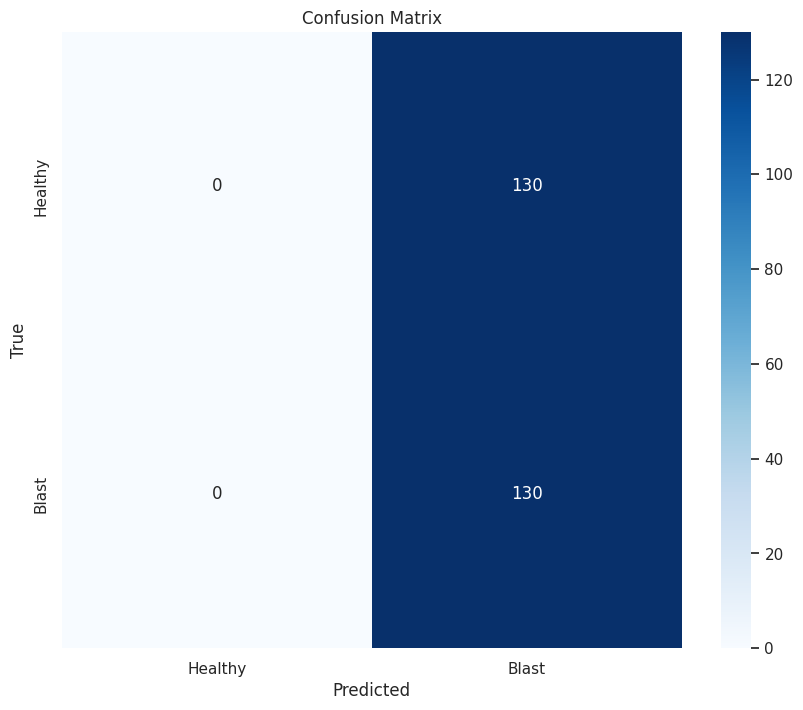

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model on the test set
evaluate_model(model, test_loader, classes=['Healthy', 'Blast'])

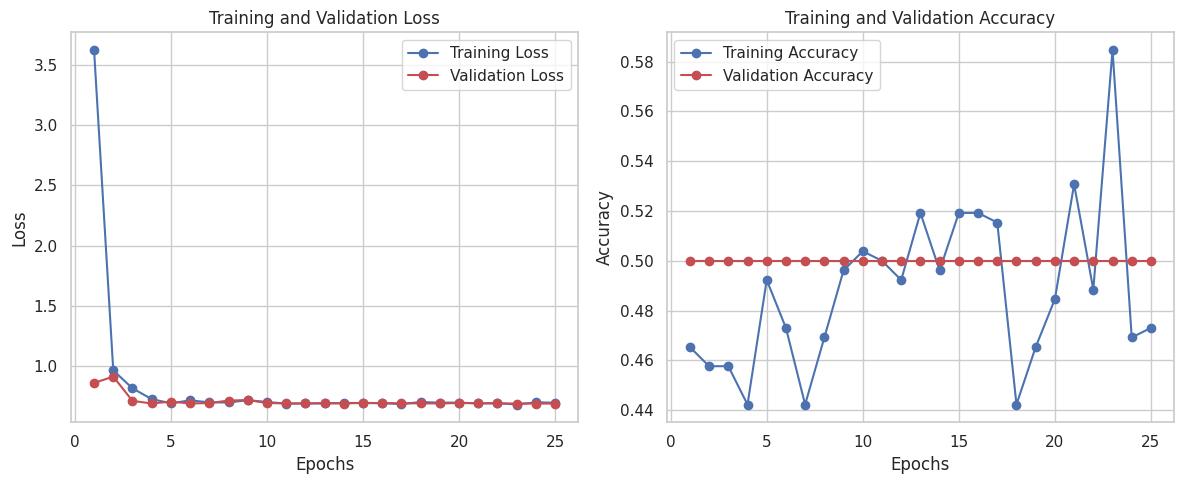

In [13]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)

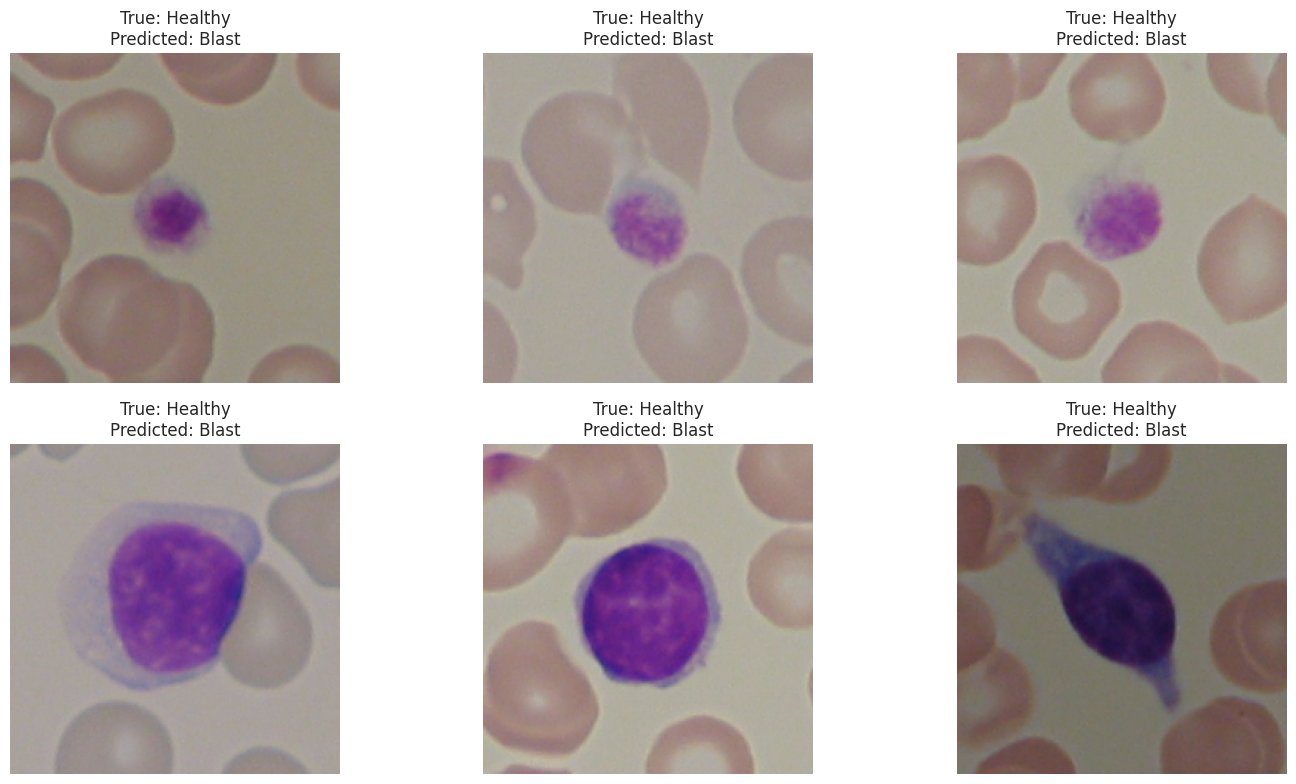

In [14]:
def visualize_predictions(model, dataloader, classes, num_images=6):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        # Display each image with true and predicted labels
        plt.subplot(2, num_images // 2, i + 1)
        img = images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)  # Un-normalize for visualization
        plt.imshow(img)
        plt.title(f"True: {classes[labels[i]]}\nPredicted: {classes[preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_predictions(model, test_loader, classes=['Healthy', 'Blast'], num_images=6)